### Тонко Ксения, 853503  

In [1]:
import numpy as np
import heapq
import pandas as pd
import math
from enum import Enum, auto
import matplotlib.pyplot as plt

In [2]:
class StatusType(Enum):
    not_handled = auto()
    rejected = auto()
    canceled = auto()

In [3]:
class Application:
    ID = 0
    
    def __init__(self, exponential_law_param, current_time):
        Application.ID += 1
        self.id = self.ID 
        self.start_time = current_time
        self.end_time = current_time + np.random.exponential(1 / exponential_law_param)
        self.is_rejected = False
        self.time_in_system = 0
        self.current_status = StatusType.not_handled
        
    def is_rejected(self, current_time):
        return current_time >= self.end_time and self.was_in_queue
    
    
    def update_app_time_in_system(self, _time):
        self.time_in_system = _time - self.start_time
        

In [4]:
class Channel:
    ID = 0
    
    def __init__(self, flow_service_intensity, Z):
        Channel.ID += 1
        self.id = self.ID
        self.flow_service_intensity = flow_service_intensity
        self.free = True
        self.service_time_end = None
        self.Z = Z
        
    def add_application(self, current_time):
        self.service_time_end = (current_time + np.random.exponential(1 / self.flow_service_intensity) + 
                                 np.random.exponential(1 / self.Z))
        self.free = False
        
    def free_channel(self, current_time):
        self.free = True
        self.service_time_end = None
        

In [5]:
class SMO:
    def __init__(self, 
                channels_count, 
                queue_amount, 
                flow_request_intensity, 
                flow_service_intensity,
                exponential_law_param,
                requests_amount,
                update_time_interval = 0.001
               ):
        self.queue_amount = queue_amount
        self.channels_count = channels_count
        self.flow_request_intensity = flow_request_intensity
        self.flow_service_intensity = flow_service_intensity
        self.exponential_law_param = exponential_law_param       
        self.requests_amount = requests_amount
        self.all_requests_amount = requests_amount
        self.update_time_interval = update_time_interval
        
        self.current_time = 0
        self.time_to_add_application = np.random.exponential(1 / flow_request_intensity)
        self.queue = []
        self.running_channels = []
        self.free_channels = [Channel(flow_service_intensity, exponential_law_param) 
                              for _ in range(channels_count)]
        Application.ID = 0
        Channel.ID = 0
        
        self.rejection = 0
        self.cancelation = 0
        self.working_channels = []
        self.queue_sizes = []
        self.current_apps = []
        self.app_queue_times = []
        self.app_system_times = []
        self.requests = 0
    
    def update_with_time(self):
        self.service_requests()
        self.get_stats()
        self.current_time += self.update_time_interval
        
    def run(self):
        while self.requests_amount:
            if self.current_time >= self.time_to_add_application:
                self.new_request()
                self.time_to_add_application += np.random.exponential(1 / self.flow_request_intensity)
            self.update_with_time()
        while len(self.running_channels):
            self.update_with_time()
            
    def new_request(self):
        self.requests_amount -=1
        app = Application(self.exponential_law_param, self.current_time)
        if self.free_channels:
            channel = self.free_channels.pop()
            
            app.update_app_time_in_system(self.current_time)
            self.app_queue_times.append(app.time_in_system)
            
            channel.add_application(self.current_time)
            app.update_app_time_in_system(channel.service_time_end)
            self.app_system_times.append(app.time_in_system)
            
            heapq.heappush(self.running_channels, (channel.service_time_end, channel.id, channel))
        else:
            if self.queue_amount > len(self.queue):
                heapq.heappush(self.queue, (app.end_time, app.id, app))
            else:
                if len(self.queue) and self.queue[0][0] < app.end_time:
                    rejected_app = heapq.heappushpop(self.queue, (app.end_time, app.id, app))[2]
                    self.add_cancel(rejected_app)
                else:
                    self.add_cancel(app)
    
    def service_requests(self):
        while self.running_channels and self.current_time >= self.running_channels[0][0]:
            channel = heapq.heappop(self.running_channels)[2]
            channel.free_channel(self.current_time)
            self.free_channels.append(channel)
            self.requests +=1
        while self.queue and self.queue[0][0] < self.current_time:            
            end_time, _, app = heapq.heappop(self.queue)
            self.add_reject(app)
        while self.queue and self.free_channels:
            end_time, _, app = heapq.heappop(self.queue)
            
            app.update_app_time_in_system(self.current_time)
            self.app_queue_times.append(app.time_in_system)
            
            channel = self.free_channels.pop()
            channel.add_application(self.current_time)
            
            channel.add_application(self.current_time)
            app.update_app_time_in_system(self.current_time)
            self.app_system_times.append(app.time_in_system)
            
            heapq.heappush(self.running_channels, (channel.service_time_end, channel.id, channel))
            
    def get_stats(self):
        self.working_channels.append(len(self.running_channels))
        self.queue_sizes.append(len(self.queue))
        self.current_apps.append(len(self.running_channels) + len(self.queue))
            
    def add_reject(self, app):
        app.is_rejected = True
        app.current_status = StatusType.rejected
        self.rejection += 1
        
    def add_cancel(self, app):
        app.current_status = StatusType.canceled
        self.cancelation += 1
        
    def get_Potk(self):
        return self.cancelation / self.all_requests_amount
    
    def get_Pi(self):
        states = list(range(self.channels_count + self.queue_amount + 1))
        pi = np.zeros(len(states))
        for req in self.current_apps:
            pi[req] += 1
        
        return states, pi    

In [6]:
n = 5
m = 2
X = 8
Y = 2
Z = 7
smo = SMO(n, m, X, Y, Z, 2000)

In [7]:
smo.run()

### Финальные вероятности 

In [8]:
states, Pi = smo.get_Pi()

In [9]:
table = pd.DataFrame(index=['Фин. вероятности'])
for i, num in enumerate(Pi):
    table[f'P{states[i]}'] = [num / sum(Pi)]

print('sum(Pi) =\t', sum([i / sum(Pi) for i in Pi]))

table

sum(Pi) =	 1.0


,P0,P1,P2,P3,P4,P5,P6,P7
Фин. вероятности,0.007008,0.045171,0.103551,0.193034,0.241453,0.234567,0.125143,0.050073


In [10]:
def get_plot(states, vals, title='Финальные вероятности состояний'):
    fig, ax = plt.subplots()

    ax.bar(states, [i / sum(vals) for i in vals], color='cyan', label='Эмпирические')

    ax.set_facecolor('seashell')
    ax.set_title(title)
    fig.set_figwidth(12)    #  ширина Figure
    fig.set_figheight(6)    #  высота Figure
    fig.set_facecolor('floralwhite')

    plt.legend()
    plt.show()

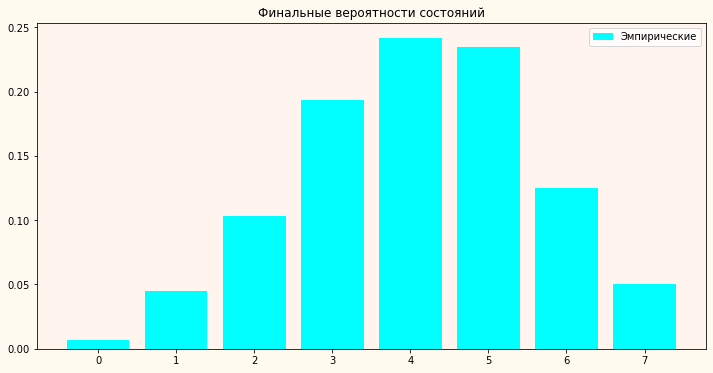

In [11]:
get_plot(states, Pi)

### Относительная пропускная способность

In [12]:
def get_Q():
    Q = 1 - P_otk
    print(f'Относительная пропускная способность Q =\t{Q}')
    return Q

###  Абсолютная пропускная способность

In [13]:
def get_A():
    A = Q * X
    print(f'Абсолютная пропускная способность A =\t{A}')
    return A

### Вероятность отказа 

In [14]:
P_otk = smo.get_Potk()
print(f'Вероятность отказа Pотк =\t{P_otk}')

Вероятность отказа Pотк =	0.0555


In [15]:
Q = get_Q()

Относительная пропускная способность Q =	0.9445


In [16]:
A = get_A()

Абсолютная пропускная способность A =	7.556


### Среднее число занятых каналов 

In [17]:
def get_k():
    k = np.mean(smo.working_channels)
    print('Среднее число занятых каналов k =\t', k)
    return k

In [18]:
k = get_k()

Среднее число занятых каналов k =	 3.8461041739901267


In [19]:
table = pd.DataFrame(index=['Характеристики эффективности'])
table['Pотк'] = [P_otk]
table['Q'] = [Q]
table['A'] = [A]
table['k'] = [k]

table

,Pотк,Q,A,k
Характеристики эффективности,0.0555,0.9445,7.556,3.846104
